In [7]:
import gzip
import os
import sys
import warnings
from collections import OrderedDict
from functools import partial

warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib.font_manager")

import logomaker
import numpy as np
import pandas as pd
from abnumber import Chain
from matplotlib import pyplot as plt
from seaborn import palettes
import csv


def Mask_position(mask_file):
    with open(mask_file, 'r') as file:
        lines = file.readlines()
        lines = [line.strip() for line in lines]
        second_line = ""
        if 'H' in lines[0]:
            second_line += lines[1]
        if 'L' in lines[2]:
            second_line += lines[3]

    positions = [index for index, char in enumerate(second_line) if char == 'X']
    return positions


def parse_fasta_string(fasta_string, to_dict=False):
    """Parses FASTA string and returns list of strings with amino-acid sequences.

    Args:
        fasta_string: The string contents of a FASTA file.

    Returns:
        A tuple of two lists:
        * A list of sequences.
        * A list of sequence ids
        * A list of sequence descriptions taken from the comment lines. In the
            same order as the sequences.
    """
    sequences = []
    ids = []
    descriptions = []
    index = -1
    for line in fasta_string.splitlines():
        line = line.strip()
        if line.startswith('>'):
            index += 1
            seq_id, *description = line[1:].split(None, 1)  # Remove the '>' at the beginning.
            ids.append(seq_id)
            if len(description) > 0:
                descriptions.append(description)
            else:
                descriptions.append("")
            sequences.append('')
            continue
        elif line.startswith('#'):
            continue
        elif not line:
            continue  # Skip blank lines.
        sequences[index] += line

    assert len(sequences) == len(ids), f"unvalid fasta file"

    if to_dict:
        return OrderedDict(zip(ids, sequences))

    return sequences, ids, descriptions


def parse_fasta(path, to_dict=False):
    """Parse the FASTA file.

    Args:
        path: path to the FASTA file (could be GZIP-compressed)

    Returns:
        prot_id: protein ID (as in the commentary line)
        aa_seq: amino-acid sequence
    """
    open_fn = partial(gzip.open, mode='rt') if path.endswith('.gz') else partial(open, mode='r')
    with open_fn(path) as f:
        fasta_string = f.read()

    return parse_fasta_string(fasta_string, to_dict=to_dict)


def write_csv(paths, seq_h, antigen_seq, seq_l=None, pkd=None, file_path='output.csv'):

    antibody_seq_b = [' '] * len(seq_h) if seq_l is None or len(seq_l) == 0 else seq_l
    pkd = [' '] * len(seq_h)
    methods = ['IgGM'] * len(seq_h)
    if paths[-1] == '' or paths[-1] is None or paths[-1] == ' ':
        methods[-1] = 'original'

    with open(file_path, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(
            ['Method', 'pdb', 'Fr1_H', 'CDR1_H', 'Fr2_H', 'CDR2_H',
             'Fr3_H',
             'CDR3_H', 'Fr4_H',
             'pkd', 'antibody_seq_h', 'antibody_seq_l', 'antigen_seq',])

        for i in range(len(seq_h)):
            chain = Chain(seq_h[i], scheme='imgt')
            fr1 = chain.fr1_seq
            fr2 = chain.fr2_seq
            fr3 = chain.fr3_seq
            fr4 = chain.fr4_seq
            cdr1 = chain.cdr1_seq
            cdr2 = chain.cdr2_seq
            cdr3 = chain.cdr3_seq
            writer.writerow(
                [methods[i], paths[i], fr1, cdr1, fr2, cdr2, fr3, cdr3,
                 fr4, pkd[i], seq_h[i], antibody_seq_b[i], antigen_seq[i]])
        print(f"CSV: {file_path} has been generated.")


def logo_plt(seqs, title='n501', out_path='./outputs/protein_A_submit_v1', highlight_positions=None,
             highlight_text=None, avg=False, positions_to_keep=None, maturation=True):
    os.makedirs(out_path, exist_ok=True)
    # ## Plot
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")

        seq_length = len(seqs[0])
        mask_length = len(positions_to_keep)
        filtered_seqs = []
        for seq in seqs:
            try:
                filtered_seq = ''.join([seq[i] for i in positions_to_keep])
            except:
                print(seq)
                print(positions_to_keep)
                print(title)
                sys.exit()
            filtered_seqs.append(filtered_seq)

        crp_counts_df = logomaker.alignment_to_matrix(sequences=filtered_seqs, to_type='counts')
        # Probability matrix, 1-100 %
        crp_counts_df[:] = crp_counts_df.values / crp_counts_df.sum(axis=1).values.reshape(-1, 1)

        if avg:
            crp_counts_df = crp_counts_df.map(lambda x: 0.501 if 0.5 < x < 0.99 else (0.499 if 0 < x < 0.5 else x))
        # crp_counts_df = crp_counts_df.map(lambda x: 1 if 0.5< x<0.99 else (0 if 0< x < 0.5 else x))
        if maturation:
            crp_counts_df = crp_counts_df.map(
                lambda x: 1 - mask_length * (1 - x) if 0.5 < x < 1.0 else (x * mask_length if 0 < x < 0.5 else x))
        ss_df = crp_counts_df.copy()
        # Custom x-ticks for posins
        # x_ticks = ss_df.index
        # Custom x-ticks for positions
        x_ticks = [positions_to_keep[i] + 1 for i in range(mask_length)]
        ss_df.index = np.arange(1, len(ss_df) + 1)
        # sns.set_style("white")
        # sns.set_palette("muted")
        colors = palettes.color_palette("cubehelix", 26)
        # colors = custom_colors
        uppercase_letters = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R',
                             'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
        colors_dict = {}
        for i, letter in enumerate(uppercase_letters):
            if letter == 'X':
                colors_dict[letter] = (1, 1, 1, 0)  # 设置为透明
            else:
                colors_dict[letter] = colors[i]

        y_ticks = np.arange(0, 50, 10).tolist()
        ax = ss_df.plot(kind='bar', color=colors_dict, stacked=True, figsize=(16, 2.5))

        plt.title(
            f'The predicted probability of the {title} amino acid mutation by IgGM')
        plt.xlabel('Residue index')
        plt.ylabel('Proportion (%)')
        # Custom x-tick labels
        ax.set_xticks(np.arange(0, len(ss_df)))
        ax.set_yticks(np.arange(0, 0.45, 0.1))

        ax.set_xticklabels(x_ticks, rotation=0)
        ax.set_yticklabels(y_ticks, rotation=0)


        ax.legend(title='Amino Acids', bbox_to_anchor=(1.05, 1), loc='upper left', ncol=3)

        plt.tight_layout()
        plt.savefig(os.path.join(out_path, 'stacked_bar_chart.png'), dpi=600)
        plt.show()

        # Plot with custom width
        fig, ax = plt.subplots(1, 1, figsize=(len(positions_to_keep), 2.5))
        ss_logo = logomaker.Logo(
            ss_df,
            width=0.8,
            vpad=0.05,
            fade_below=0.2,
            # fade_probabilities=True,
            stack_order="big_on_top",
            color_scheme=colors_dict,
            ax=ax,
        )

        # Style using LOGO methods
        ss_logo.style_spines(spines=["left", "right"], visible=False)
        ss_logo.ax.set_ylabel("Probability", )
        ss_logo.ax.set_xlabel("Amino Acid Position")

        # Custom x-tick labels
        ax.set_xticks(np.arange(1, len(ss_df) + 1))
        ax.set_xticklabels(x_ticks, rotation=0)

        # Highlight specific positions
        if highlight_positions is not None:
            for pos, text in zip(highlight_positions, highlight_text):
                if 1 <= pos <= len(ss_df):
                    ax.text(pos, -0.09, str(text), ha='center', va='center', fontsize=12, fontweight='bold',
                            color='red')
        # Custom y-ticks as percentage
        ax.set_yticklabels([f"{int(i * 100)}" for i in ax.get_yticks()])
        plt.title(title)

        # Save
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
        # plt.tight_layout()
        plt.savefig(os.path.join(out_path, 'logo.png'), bbox_inches="tight", dpi=600)
        print(f"Saving probability plot to {out_path}")
        plt.show()



def find_diff_and_freq(df_file, dup_df_file, original_seq_h=None, original_seq_l=None, seq_h_name='antibody_seq_h',
                       seq_l_name='antibody_seq_l', Heavy_Change_name='Heavy Change Info',
                       Light_Change_name='Light Change Info', return_freq=True):
    df = pd.read_csv(df_file)
    dup_df = pd.read_csv(dup_df_file)
    antibody_seq_a = df[seq_h_name]
    antibody_seq_b = df[seq_l_name]

    df[Heavy_Change_name] = ''
    df[Light_Change_name] = ''

    if original_seq_h is not None:
        for index, (seq1, seq2) in enumerate(zip(antibody_seq_a, antibody_seq_b)):

            min_length_h = min(len(seq1), len(original_seq_h))

            changes = []

            change_num = 0
            for i in range(min_length_h):
                if seq1[i] != original_seq_h[i]:
                    changes.append(f"Pos: {i + 1}, {original_seq_h[i]} -> {seq1[i]}")
                    change_num += 1

            if changes:
                df.at[index, Heavy_Change_name] = '; '.join(changes)

            df.at[index, 'Heavy Change Num'] = change_num

            if original_seq_l is not None:
                min_length_l = min(len(seq2), len(original_seq_l))
                changes = []
                change_num = 0
                for i in range(min_length_l):
                    if seq2[i] != original_seq_l[i]:
                        changes.append(f"Pos: {i + 1}, {original_seq_l[i]} -> {seq2[i]}")
                        change_num += 1
                if changes:
                    df.at[index, 'Light Change Info'] = '; '.join(changes)
                df.at[index, 'Light Change Num'] = change_num

    if return_freq:
        df['combined_seq'] = df[seq_h_name] + df[seq_l_name]
        dup_df['combined_seq'] = dup_df['antibody_seq_h'] + dup_df['antibody_seq_l']

        frequency = dup_df['combined_seq'].value_counts()
        df['Frequency'] = df['combined_seq'].map(frequency).fillna(0).astype(int)
        del df['combined_seq']

    if 'Heavy Change Num' in df.columns and 'Light Change Num' in df.columns:
        df = df[~((df['Heavy Change Num'] == 0) & (df['Light Change Num'] == 0))]

    if 'Frequency' in df.columns:
        df = df.sort_values(by='Frequency', ascending=False)

    return df


def run_collect_plot(fasta_dir, mask_file_path, original_seq_h=None, original_seq_l=None, maturation=True):
    if not os.path.exists(fasta_dir):
        print(f'{fasta_dir} not exists')
        return
    target = fasta_dir.split('/')[-1]
    fastas_list = os.listdir(fasta_dir)
    fastas_list = [f for f in fastas_list if f.endswith('.fasta')]

    seqs_h = []
    seqs_antigen = []
    seqs_l = []
    for fasta in fastas_list:
        fasta_path = os.path.join(fasta_dir, fasta)
        sequences, ids, _ = parse_fasta(fasta_path)
        seqs_h.append(sequences[0])
        if len(sequences) == 2:
            seqs_antigen.append(sequences[1])
            seqs_l = None
        else:
            seqs_antigen.append(sequences[2])
            seqs_l.append(sequences[1])
    antigen_seq = seqs_antigen[0]
    original_fasta_path_predict = None

    seqs_h_set, seqs_l_set = set(), set()
    dedup_files_list, dedup_seqs_h_list, dedup_seqs_l_list = [], [], []
    dup_files_list, dup_seqs_h_list, dup_seqs_l_list = [], [], []

    if seqs_l is not None:
        for fasta_file, seq_h, seq_l in zip(fastas_list, seqs_h, seqs_l):
            dup_files_list.append(fasta_file)
            dup_seqs_h_list.append(seq_h)
            dup_seqs_l_list.append(seq_l)

            if seq_h not in seqs_h_set or seq_l not in seqs_l_set:
                if original_seq_h is not None:
                    if seq_h in original_seq_h:
                        if original_seq_l is not None:
                            if seq_l in original_seq_l:
                                original_fasta_path_predict = fasta_file
                                continue
                        else:
                            original_fasta_path_predict = fasta_file
                            continue
                seqs_h_set.add(seq_h)
                seqs_l_set.add(seq_l)
                dedup_files_list.append(fasta_file)
                dedup_seqs_h_list.append(seq_h)
                dedup_seqs_l_list.append(seq_l)

    else:
        for fasta_file, seq_h in zip(fastas_list, seqs_h):
            dup_files_list.append(fasta_file)
            dup_seqs_h_list.append(seq_h)
            if seq_h not in seqs_h_set:
                seqs_h_set.add(seq_h)
                dedup_files_list.append(fasta_file)
                dedup_seqs_h_list.append(seq_h)
                if seq_h in original_seq_h:
                    original_fasta_path_predict = fasta_file

    dup_files_list = [os.path.join(fasta_dir, f) for f in dup_files_list]
    dedup_files_list = [os.path.join(fasta_dir, f) for f in dedup_files_list]
    positions_to_keep = Mask_position(mask_file_path)

    # for duplicate
    if seqs_l is not None:
        dup_seqs_h_list_plot = [seq + seq_l for seq, seq_l in zip(seqs_h, seqs_l)]
    else:
        dup_seqs_h_list_plot = seqs_h
    out_path = os.path.join(fasta_dir.replace(target, 'results'), target)
    logo_plt(dup_seqs_h_list_plot, title=target, out_path=os.path.join(out_path, 'dup'),
             positions_to_keep=positions_to_keep, maturation=maturation)


    # add original seq
    if original_seq_h is not None:
        original_seq_plot = [original_seq_h] if original_seq_l is None else [original_seq_h + original_seq_l]
        logo_plt(original_seq_plot, title=f'{target}_original', out_path=os.path.join(out_path, 'original'),
                 positions_to_keep=positions_to_keep, maturation=maturation)

        dup_files_list.append(original_fasta_path_predict)
        dedup_files_list.append(original_fasta_path_predict)
        dup_seqs_h_list.append(original_seq_h)
        dedup_seqs_h_list.append(original_seq_h)
        if seqs_l is not None:
            dup_seqs_l_list.append(original_seq_l)
            dedup_seqs_l_list.append(original_seq_l)
    seqs_antigen.append(antigen_seq)

    write_csv(dup_files_list, dup_seqs_h_list, seqs_antigen, dup_seqs_l_list,
              file_path=os.path.join(out_path, 'dup.csv'))
    write_csv(dedup_files_list, dedup_seqs_h_list, seqs_antigen, dedup_seqs_l_list,
              file_path=os.path.join(out_path, 'dedup.csv'))


    # for diff and freq
    df = find_diff_and_freq(os.path.join(out_path, 'dedup.csv'), os.path.join(out_path, 'dup.csv'), original_seq_h,
                            original_seq_l)
    df.to_csv(os.path.join(out_path, 'dedup_diff_freq.csv'), index=False)


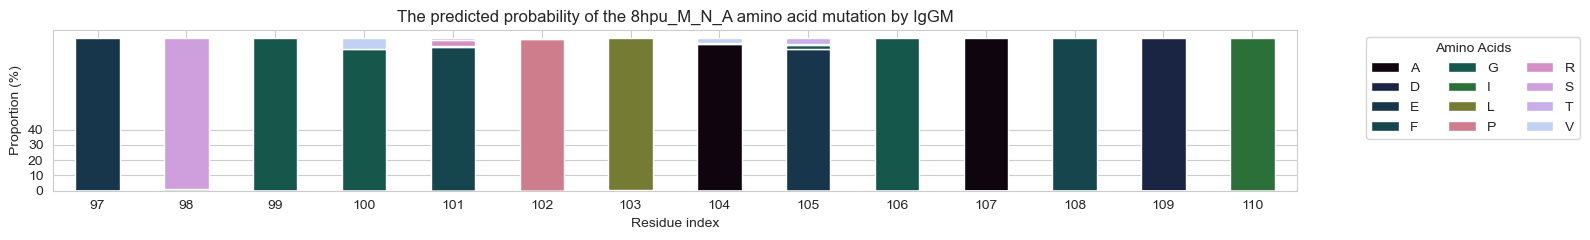

Saving probability plot to outputs/maturation/results/8hpu_M_N_A/dup


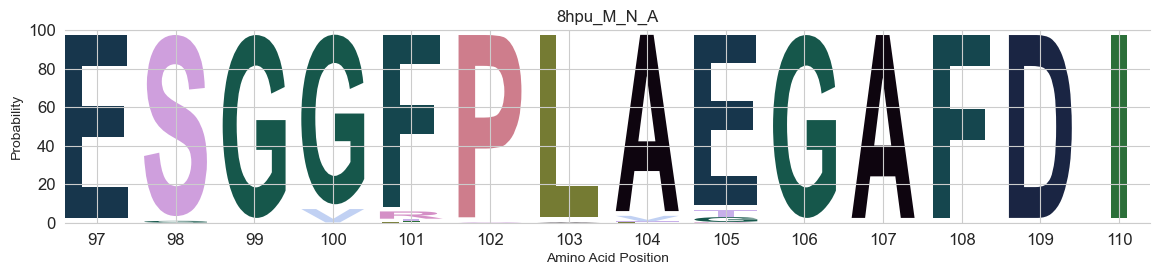

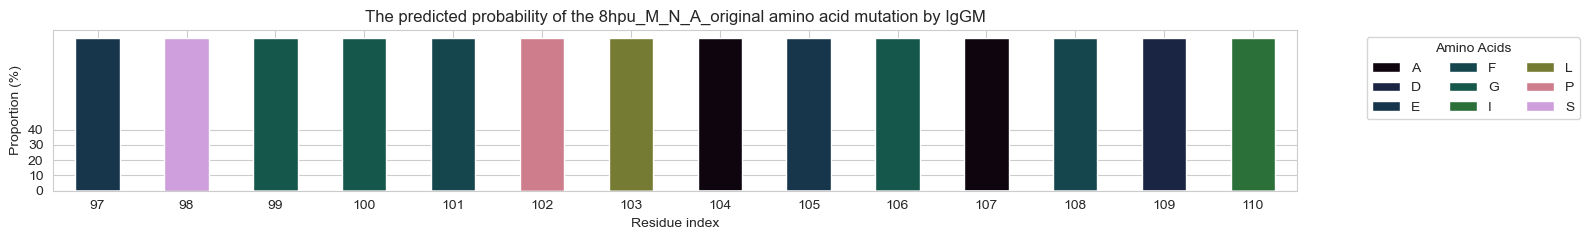

Saving probability plot to outputs/maturation/results/8hpu_M_N_A/original


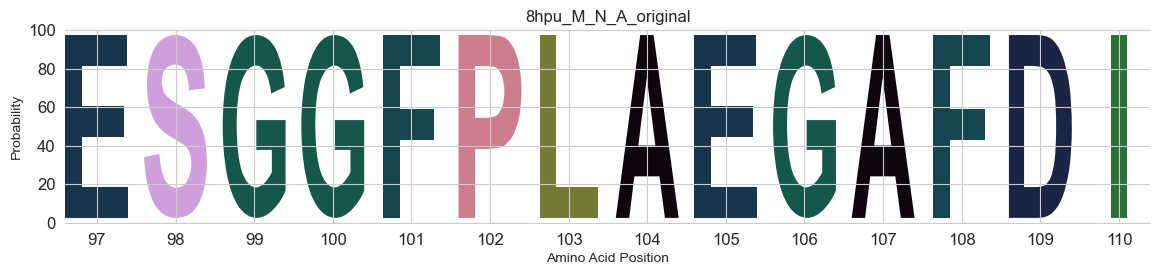

CSV: outputs/maturation/results/8hpu_M_N_A/dup.csv has been generated.
CSV: outputs/maturation/results/8hpu_M_N_A/dedup.csv has been generated.


In [8]:
prot_ids = ['8hpu_M_N_A']
design_region = 'CDR_H3' # "CDR_All", "CDR_H1", "CDR_H2", "CDR_H3", "CDR_L1", "CDR_L2", "CDR_L3"


original_fasta_list = [f"examples/fasta.files.native/{prot_id}.fasta" for prot_id in prot_ids]
mask_fasta_list = [f"examples/fasta.files.design/{prot_id}/{prot_id}_{design_region}.fasta" for prot_id in prot_ids]
output_fasta_list = [
    f"outputs/maturation/{prot_id}" for prot_id in prot_ids]

for fasta_dir, mask_file, original_fasta in zip(output_fasta_list, mask_fasta_list, original_fasta_list):
    original_seq_h = parse_fasta(original_fasta)[0][0]
    original_seq_l = parse_fasta(original_fasta)[0][1]
    run_collect_plot(fasta_dir, mask_file, original_seq_h=original_seq_h, original_seq_l=original_seq_l, maturation=False)